# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given an SARS-CoV-2 assay. [PostEra.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

1. [Reading data](#reading_data)    
    a. [Activity data](#activity_data)    
    b. [Molecular docking and molecular descriptors](#molecular)    
    
    
2. [Machine learning](#machine_learning)     
    a. [Constructing the models](#constructing_models)     
    b. [Evaluation metrics](#evaluation_metrics)     
    
    
3. [Performace analysis](#performance_analysis)    
    a. [Comparing models and labels](#comparing)    
    b. [Finding the best subset](#finding)      
    c. [Reconstructing the top models](#reconstructing)    
    d. [ROC curves](#roc_curves)    
    e. [Regression plots](#regression)    
    
    
4. [Supplementary data](#supplementary)    

<a id='reading_data'></a>
## Reading data

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<a id='activity_data'></a>
### Activity data

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


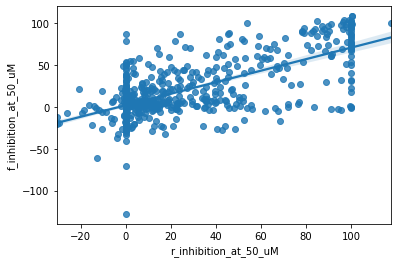

In [3]:
# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

<a id='molecular'></a>
### Molecular docking and molecular descriptors

In [4]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']])
del tmp

# Read descriptors
descriptors = pd.read_csv('descriptors.csv')

# Merge descriptors to "top"
data = pd.merge(descriptors, top)
data.rename({'VABC Volume Descriptor': 'Volume', 
             'Rotatable Bonds Count': 'RotatableBonds', 
             'Topological Polar Surface Area': 'TPSA', 
             'Molecular Weight': 'MolecularWeight'}, axis=1, inplace=True)

data['Volume'] = data['Volume'].astype(float)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data

,CID,Volume,RotatableBonds,TPSA,MolecularWeight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,f_inhibition_at_50_uM,r_active,f_active
0,MAT-POS-02ae579f-1,471.863944,13,62.55,498.231871,6.428,-7.7,7.746907,-93.0745,7.544520,NaN,0.007703,0,0
1,MAT-POS-02ae579f-2,234.513225,2,82.70,267.112010,0.594,-7.2,6.285345,-80.1747,6.407342,NaN,2.287651,0,0
2,LOR-NOR-f9b26152-1,158.860109,3,55.40,195.033171,1.090,-5.5,4.929599,-59.7841,5.100658,7.794489,3.016446,0,0
3,LON-WEI-2e27a2e5-2,482.430779,13,75.19,510.243104,5.224,-7.3,7.575922,-97.6586,7.776974,NaN,-6.337255,0,0
4,MAT-POS-af71705c-1,264.262203,3,76.02,294.111676,2.720,-6.2,6.609277,-54.8444,6.834465,0.000000,-0.727192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,DAR-DIA-842b4336-4,194.685235,3,82.26,253.007661,0.906,-6.2,5.742401,-72.5664,6.278891,35.740000,23.748390,0,0
939,DAR-DIA-842b4336-7,180.752130,3,80.05,218.080376,0.102,-6.0,5.662361,-62.9061,5.673960,8.515000,8.855559,0,0
940,DAR-DIA-842b4336-13,200.984459,4,70.23,252.012412,0.862,-5.9,6.208389,-72.0692,6.147168,NaN,11.500410,0,0
941,DAR-DIA-842b4336-16,187.051354,4,68.02,217.085127,-0.371,-5.8,5.827959,-66.4762,5.898676,0.000000,-9.906875,0,0


In [5]:
# Descriptors
descriptor_list = list(data.columns[1:-8])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

train_set = descriptor_list + docking_list

data.dropna(subset=train_set, inplace=True)

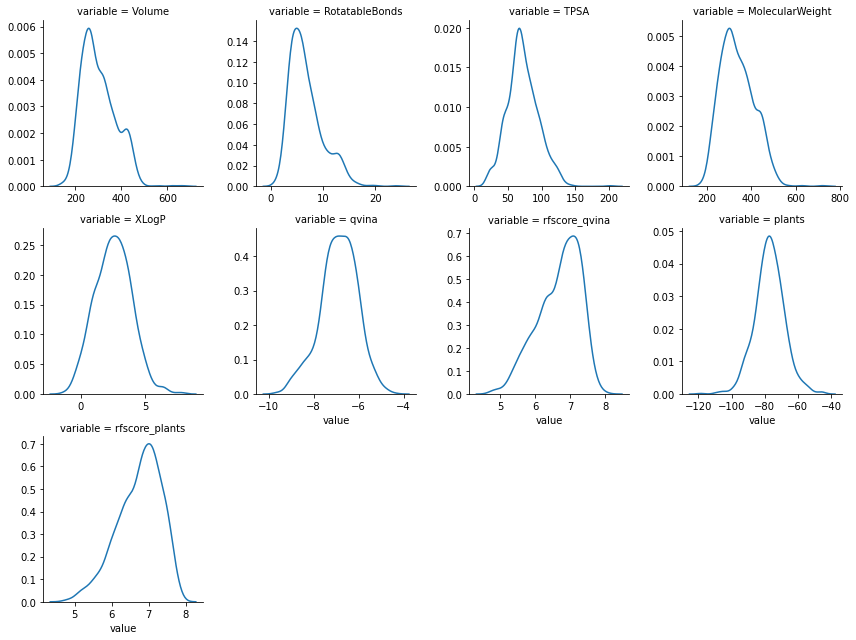

In [6]:
melt = pd.melt(data, id_vars=['CID'], value_vars=train_set)
g = sns.FacetGrid(data=melt, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value')

In [7]:
def qq_plot(X, nrows, ncols):
    from scipy.stats import probplot

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows * 6.4, ncols * 4.8))
    for i, x in enumerate(X.columns):
        probplot(data[x], dist='norm', plot=ax[i//nrows, i%ncols])
        ax[i//nrows, i%ncols].set_title(x)

    fig.tight_layout()
    plt.show()

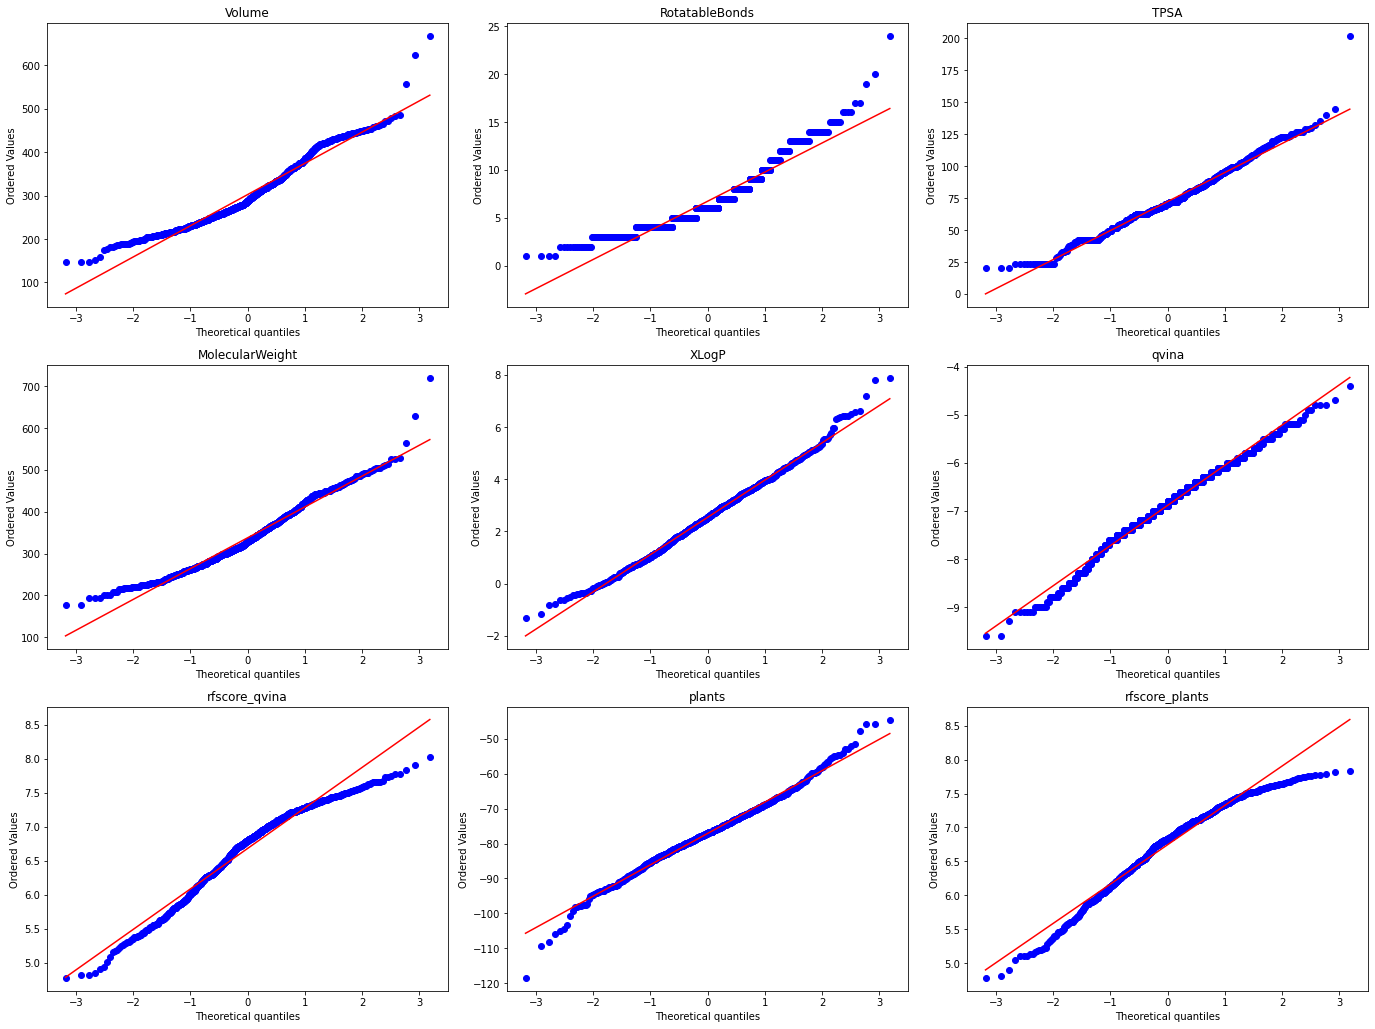

In [8]:
qq_plot(X=data[train_set], nrows=3, ncols=3)

The data is approximately normaly distributed, and can be standardized. However, some descriptors ṕresent skewness and the QQ-Plot shows the outermost data has greater variance, which could indicate heteroskedacity (non-constant variance). Therefore, the data will be rescaled with PowerTransformer(), which normalizes data and minimizes its skewness, making it more Gaussian-like, according to the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html). 

<a id='machine_learning'></a>
## Machine learning

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import multiprocessing
from functools import partial
import itertools
import time

<a id='constructing_models'></a>
### Constructing the models

In [10]:
# Get all subsets of a "main" list and N other lists
def get_combinations(min_len, list1, *args):
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(itertools.combinations(list2, r) for r in range(min_len, len(list2)+1)))
    
    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [11]:
# Rebalance data with SMOTE and cross validate model
def get_scores(X_train, X_test, y_train, y_test, subset, train_set, activity_label, model):
    model_fitted = model.fit(X_train, y_train)

    y_pred = model_fitted.predict(X_test)

    scores = [accuracy_score(y_test, y_pred), # test_accuracy
              f1_score(y_test, y_pred), # test_f1
              precision_score(y_test, y_pred), # test_precision
              recall_score(y_test, y_pred), # test_recall
              roc_auc_score(y_test, y_pred), # test_roc_auc
             ]
    
    scores.append(activity_label)
    scores.append(str(model).split('(')[0])
    
    # Add binary list of the descriptors present (1) or not present (0) in the subset
    scores.extend([1 if i in subset else 0 for i in train_set])
    
    return scores

In [12]:
def run_models(data, scaler, train_set, combinations, columns):
    ncpu = multiprocessing.cpu_count()

    # DataFrame for all models' scores
    scores_data = pd.DataFrame()

    model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                     RandomForestClassifier(n_estimators=10, random_state=13), 
                     KNeighborsClassifier(n_neighbors=3), 
                     LinearSVC(dual=False, random_state=13), 
                     XGBClassifier(objective='reg:logistic', random_state=13), 
                     DecisionTreeClassifier(random_state=13), 
                     GaussianNB(), 
                     LinearDiscriminantAnalysis(solver='svd')]
    
    for activity_label in ['r_active','f_active']:
        # Drop NaN activity and descriptor values
        new_data = data.dropna(subset=[activity_label])

        # Loop through all subset combinations (2, N)
        for subset in combinations:
            subset = list(subset)
            
            y = new_data[activity_label]
            X = new_data[subset]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
            
            # Apply SMOTE to training data and keep original test data
            sm = SMOTE(random_state=27)
            X_train, y_train = sm.fit_sample(X_train, y_train)
            
            # Transform data with float values (keep original int columns)
            float_cols = [i for i in X.columns if X[i].dtype == float]
            
            X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
            X_test[float_cols] = scaler.transform(X_test[float_cols])
            
            args = []
            for model in model_list:
                args.append((activity_label, model))
            
            with multiprocessing.Pool(processes=ncpu) as pool:
                scores = pool.starmap(partial(get_scores, X_train, X_test, y_train, y_test, 
                                              subset, train_set), args)

            # Append scores to all scores
            scores = pd.DataFrame(scores, columns=columns+train_set)
            scores_data = scores_data.append(scores)
                
    return scores_data

<a id='evaluation_metrics'></a>
### Evaluation metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [13]:
# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptor_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','f1','precision','recall','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]

columns = [*test_metrics, 'activity_label', 'model']

In [14]:
t0 = time.time()

## Run all!
#scores_data = run_models(data, StandardScaler(), train_set, combinations, columns)
#scores_data.to_csv('scores_data.csv', index=False)

t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

3m:14.2167s


<a id='performance_analysis'></a>
## Performance analysis

In [36]:
# Read test scores and sort values
scores_data = pd.read_csv('scores_data.csv')
columns = scores_data.columns

scores_data['test_mean'] = scores_data[test_metrics].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.head()

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,activity_label,model,Volume,RotatableBonds,TPSA,MolecularWeight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
3313,0.838983,0.536585,0.500000,0.578947,0.733918,f_active,RandomForestClassifier,0,1,1,1,1,0,0,1,0,0.637687
3097,0.843220,0.531646,0.512195,0.552632,0.725811,f_active,RandomForestClassifier,0,1,1,1,0,0,0,0,1,0.633101
2329,0.851695,0.520548,0.542857,0.500000,0.709596,f_active,RandomForestClassifier,0,1,1,1,0,1,0,0,0,0.624939
3089,0.826271,0.517647,0.468085,0.578947,0.726342,f_active,RandomForestClassifier,0,1,1,1,0,0,0,1,0,0.623459
2017,0.834746,0.518519,0.488372,0.552632,0.720760,f_active,RandomForestClassifier,0,1,1,0,0,1,0,0,0,0.623006


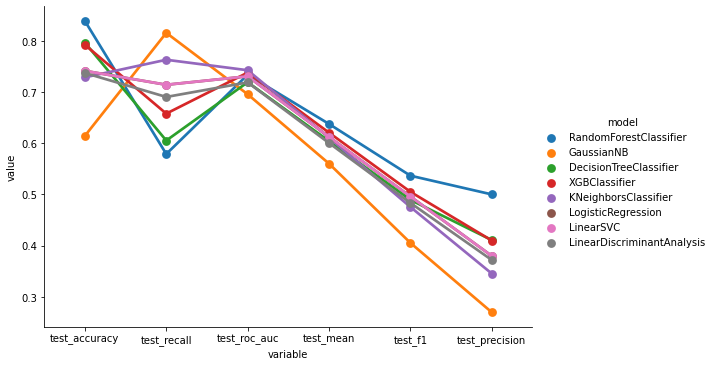

In [37]:
top = pd.melt(scores_data.groupby('model').head(1), id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', aspect=1.5)

<a id='comparing'></a>
### Comparing models and labels

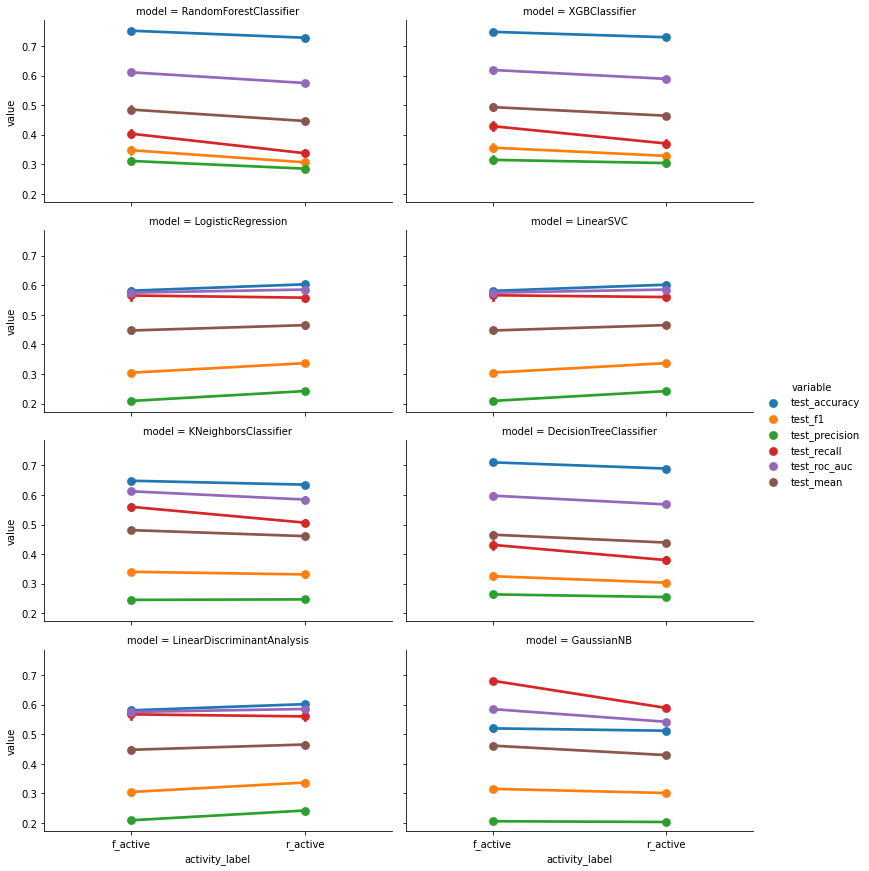

In [38]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*train_set], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

We see here the best classification metric ("RapidFire" or fluorescence) varies a bit for each model. While Linear SVC and Logistic Regression performed better with "RapidFire" activity labels, K-Nearest Neighbors and Random Forest classifiers performed better with the fluorescence activity labels.
<a id='finding'></a>
### Finding the best subset

In [39]:
# Dictionary: key == model_name, value == tuple(activity label, list of best descriptors)
best_subset = {}

for i, row in scores_data.groupby('model').head(1).iterrows():
    best_subset[row['model']] = [row['activity_label']]
    best_subset[row['model']].append([descriptor for descriptor in train_set if row[descriptor]])

In [40]:
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])

Text(0.5, 1.05, 'test_roc_auc')

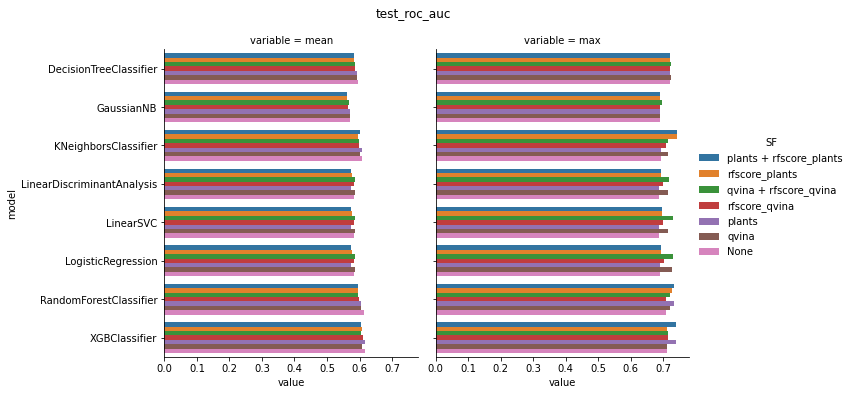

In [41]:
# Do the scores increase when I add the docking scoring functions?
sns.catplot(kind='bar', data=compare, y='model', x='value', col='variable', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.     
<a id='reconstructing'></a>
### Reconstructing the top models

In [42]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

In [43]:
def get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted):    
    y_pred_train = model_fitted.predict(X_train)
    y_pred_test = model_fitted.predict(X_test)

    scores = [accuracy_score(y_test, y_pred_test), # test_accuracy
              f1_score(y_test, y_pred_test), # test_f1
              precision_score(y_test, y_pred_test), # test_precision
              recall_score(y_test, y_pred_test), # test_recall
              roc_auc_score(y_test, y_pred_test), # test_roc_auc
              accuracy_score(y_train, y_pred_train), # train_accuracy
              f1_score(y_train, y_pred_train), # train_f1
              precision_score(y_train, y_pred_train), # train_precision
              recall_score(y_train, y_pred_train), # train_recall
              roc_auc_score(y_train, y_pred_train), # train_roc_auc
             ]
    
    return scores

In [44]:
def get_model_by_name(model_name):
    if model_name == 'LogisticRegression':
        model = LogisticRegression(solver='liblinear', random_state=13)
    elif model_name == 'LinearSVC':
        model = CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=10, random_state=13)
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(n_neighbors=3)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(objective='reg:logistic', random_state=13)
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=13)
    elif model_name == 'LinearDiscriminantAnalysis':
        model = LinearDiscriminantAnalysis(solver='svd')
    else:
        model = GaussianNB()
    return model

In [45]:
# Top models' probabilities
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List with each top model's scores
scores_list = []
new_data = data.dropna(subset=train_set)

count = 0
for key, value in best_subset.items():
    model_name = key
    activity_label = value[0]
    subset = value[1]
    
    y = new_data[activity_label]
    X = new_data[subset]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
    
    # Apply SMOTE to training data and keep original test data
    sm = SMOTE(random_state=27)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    
    # Resize train set to fit in "train_data" (the number of samples generated by SMOTE was 1204 
    # for KNeighborsClassifier whereas the number of generated samples for the other models was 1206, 
    # so the results wouldn't fit in the same DataFrame)
    n_samples = len(train_data)
    if(n_samples > 0):
        if(n_samples < len(X_train)):
            X_train = X_train[:n_samples]
            y_train = y_train[:n_samples]
        else:
            train_data = train_data[:len(X_train)]

    scaler = StandardScaler()
    # Transform data with float values (keep original int columns)
    float_cols = [i for i in X.columns if X[i].dtype == float]
    
    X_train[float_cols] = scaler.fit_transform(X_train[float_cols])
    X_test[float_cols] = scaler.transform(X_test[float_cols])
    
    model = get_model_by_name(model_name)
    
    model_fitted = model.fit(X_train, y_train)
    scores = get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted)
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

test_metrics = ['test_'+ i for i in scoring_metrics]
train_metrics = ['train_'+ i for i in scoring_metrics]
columns = ['model', *test_metrics, *train_metrics]

top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

,model,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,test_mean,train_mean
0,RandomForestClassifier,0.838983,0.536585,0.500000,0.578947,0.733918,0.994300,0.994304,0.993496,0.995114,0.994300,0.637687,0.994303
1,XGBClassifier,0.792373,0.505051,0.409836,0.657895,0.738038,1.000000,1.000000,1.000000,1.000000,1.000000,0.620638,1.000000
2,LogisticRegression,0.741525,0.495868,0.379747,0.714286,0.730854,0.710440,0.707819,0.714286,0.701468,0.710440,0.612456,0.708891
3,LinearSVC,0.741525,0.495868,0.379747,0.714286,0.730854,0.712887,0.710049,0.717138,0.703100,0.712887,0.612456,0.711212
4,KNeighborsClassifier,0.724576,0.471545,0.341176,0.763158,0.740165,0.886623,0.893323,0.842258,0.950980,0.886728,0.608124,0.891982
5,DecisionTreeClassifier,0.775424,0.442105,0.368421,0.552632,0.685407,0.991028,0.990961,0.996694,0.985294,0.991018,0.564798,0.990999
6,LinearDiscriminantAnalysis,0.737288,0.483333,0.371795,0.690476,0.718949,0.713703,0.712059,0.716172,0.707993,0.713703,0.600368,0.712726
7,GaussianNB,0.614407,0.405229,0.269565,0.815789,0.695774,0.603589,0.627301,0.591040,0.668301,0.603694,0.560153,0.618785


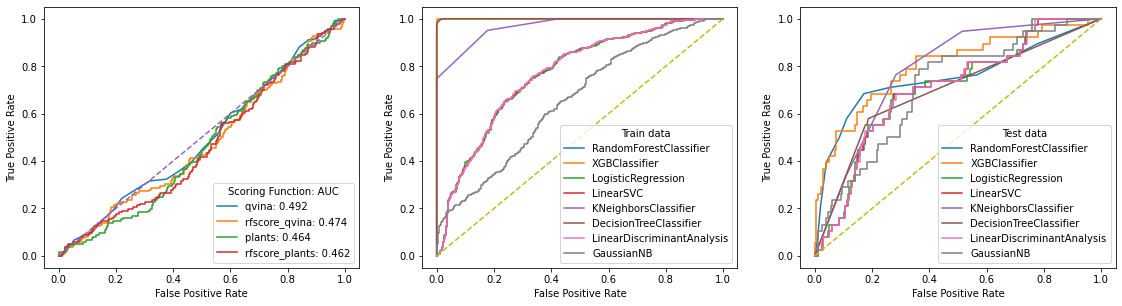

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data['r_active'].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')
plt.savefig('roc_curve.png')

top_scores

In [47]:
scores_data.sort_values('test_mean', ascending=False).groupby('model').head(1)

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,activity_label,model,Volume,RotatableBonds,TPSA,MolecularWeight,XLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
3313,0.838983,0.536585,0.500000,0.578947,0.733918,f_active,RandomForestClassifier,0,1,1,1,1,0,0,1,0,0.637687
3092,0.792373,0.505051,0.409836,0.657895,0.738038,f_active,XGBClassifier,0,1,1,1,0,0,0,1,0,0.620638
952,0.741525,0.495868,0.379747,0.714286,0.730854,r_active,LogisticRegression,1,1,1,1,1,1,1,0,0,0.612456
955,0.741525,0.495868,0.379747,0.714286,0.730854,r_active,LinearSVC,1,1,1,1,1,1,1,0,0,0.612456
2898,0.728814,0.475410,0.345238,0.763158,0.742690,f_active,KNeighborsClassifier,0,0,1,1,0,0,0,0,1,0.611062
2005,0.796610,0.489362,0.410714,0.605263,0.719298,f_active,DecisionTreeClassifier,0,1,1,1,0,0,0,0,0,0.604250
959,0.737288,0.483333,0.371795,0.690476,0.718949,r_active,LinearDiscriminantAnalysis,1,1,1,1,1,1,1,0,0,0.600368
2422,0.614407,0.405229,0.269565,0.815789,0.695774,f_active,GaussianNB,0,0,1,1,0,1,1,0,0,0.560153


We can see that Logistic Regression and Linear SVC were the best models and that they yielded very similar results.         
Considering Logistic Regression is the most frequent one in the top scores, we can assume it is the most adequate model for our problem.

<a id='regression'></a>
### Regression plots

In [48]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

del tmp

Text(0.5, 0.98, 'Regression plots for the test set')

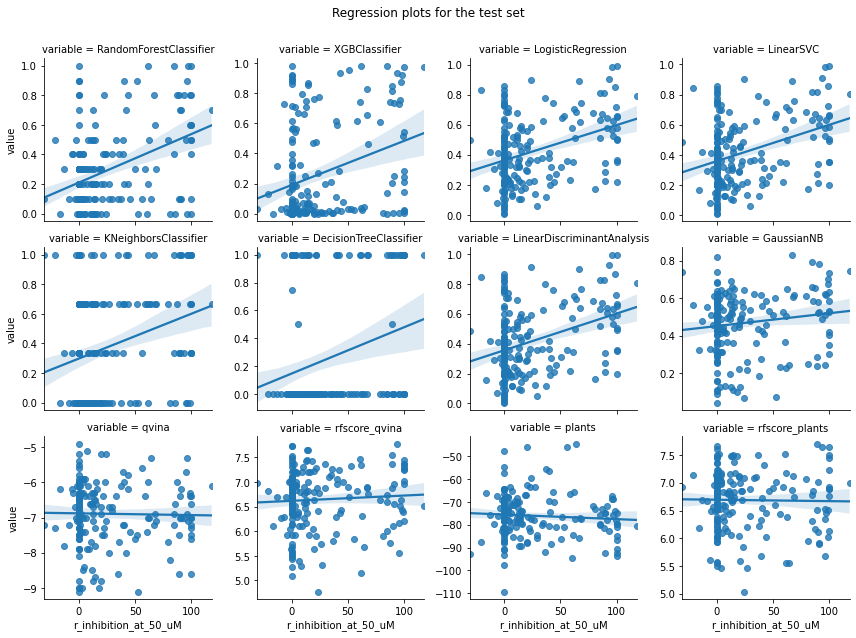

In [49]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'r_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

In [50]:
# Pearson correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.676306
f_inhibition_at_50_uM,0.676306,1.000000
DecisionTreeClassifier,0.286205,0.366167
GaussianNB,0.162891,0.196047
KNeighborsClassifier,0.312330,0.383570
LinearDiscriminantAnalysis,0.381779,0.280182
LinearSVC,0.382248,0.279834
LogisticRegression,0.383475,0.280387
RandomForestClassifier,0.443483,0.454247


In [51]:
# Spearman correlations with "r_inhibition_at_50_uM"
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.532501
f_inhibition_at_50_uM,0.532501,1.000000
DecisionTreeClassifier,0.254247,0.318972
GaussianNB,0.128612,0.185028
KNeighborsClassifier,0.299323,0.362962
LinearDiscriminantAnalysis,0.299718,0.281210
LinearSVC,0.298569,0.279691
LogisticRegression,0.298646,0.282606
RandomForestClassifier,0.346594,0.328056


<a id='supplementary'></a>
## Supplementary data

In [52]:
df = scores_data.groupby(['model','activity_label']).describe()

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_active               214.0  0.710300  0.047191   
                           r_active               214.0  0.689292  0.038769   
GaussianNB                 f_active               214.0  0.519840  0.058700   
                           r_active               214.0  0.511900  0.056239   
KNeighborsClassifier       f_active               214.0  0.648048  0.045858   
                           r_active               214.0  0.634979  0.041289   
LinearDiscriminantAnalysis f_active               214.0  0.580825  0.056670   
                           r_active               214.0  0.601655  0.062809   
LinearSVC                  f_active               214.0  0.581003  0.056625   
                           r_active               214.0  0.601933  0.062819   
LogisticRegression         f_active               214.0  0.581696  0.054632   
                           r_active               214.0  0.603140  0.061630   
RandomForestClassifier     f_active               214.0  0.751703  0.053729   
                           r_active               214.0  0.727982  0.040520   
XGBClassifier              f_active               214.0  0.747842  0.058885   
                           r_active               214.0  0.729625  0.051273   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_active        0.538136  0.682203  0.716102   
                           r_active        0.516949  0.665254  0.692797   
GaussianNB                 f_active        0.394068  0.471398  0.521186   
                           r_active        0.381356  0.461864  0.533898   
KNeighborsClassifier       f_active        0.500000  0.622881  0.650424   
                           r_active        0.500000  0.610169  0.635593   
LinearDiscriminantAnalysis f_active        0.427966  0.542373  0.582627   
                           r_active        0.444915  0.559322  0.593220   
LinearSVC                  f_active        0.427966  0.542373  0.584746   
                           r_active        0.444915  0.559322  0.593220   
LogisticRegression         f_active        0.427966  0.542373  0.584746   
                           r_active        0.444915  0.563559  0.593220   
RandomForestClassifier     f_active        0.546610  0.717161  0.758475   
                           r_active        0.550847  0.703390  0.733051   
XGBClassifier              f_active        0.555085  0.716102  0.758475   
                           r_active        0.495763  0.699153  0.741525   

                                                              test_f1  \
                                                75%       max   count   
model                      activity_label                               
DecisionTreeClassifier     f_active        0.744703  0.805085   214.0   
                           r_active        0.711864  0.775424   214.0   
GaussianNB                 f_active        0.567797  0.656780   214.0   
                           r_active        0.562500  0.605932   214.0   
KNeighborsClassifier       f_active        0.677966  0.745763   214.0   
                           r_active        0.661017  0.728814   214.0   
LinearDiscriminantAnalysis f_active        0.614407  0.707627   214.0   
                           r_active        0.648305  0.737288   214.0   
LinearSVC                  f_active        0.613347  0.703390   214.0   
                           r_active        0.648305  0.741525   214.0   
LogisticRegression         f_active        0.614407  0.694915   214.0   
                           r_active        0.651483  0.741525   214.0   
RandomForestClassif

Text(0.5, 0.98, 'Most frequent descriptors in the top 1% scores')

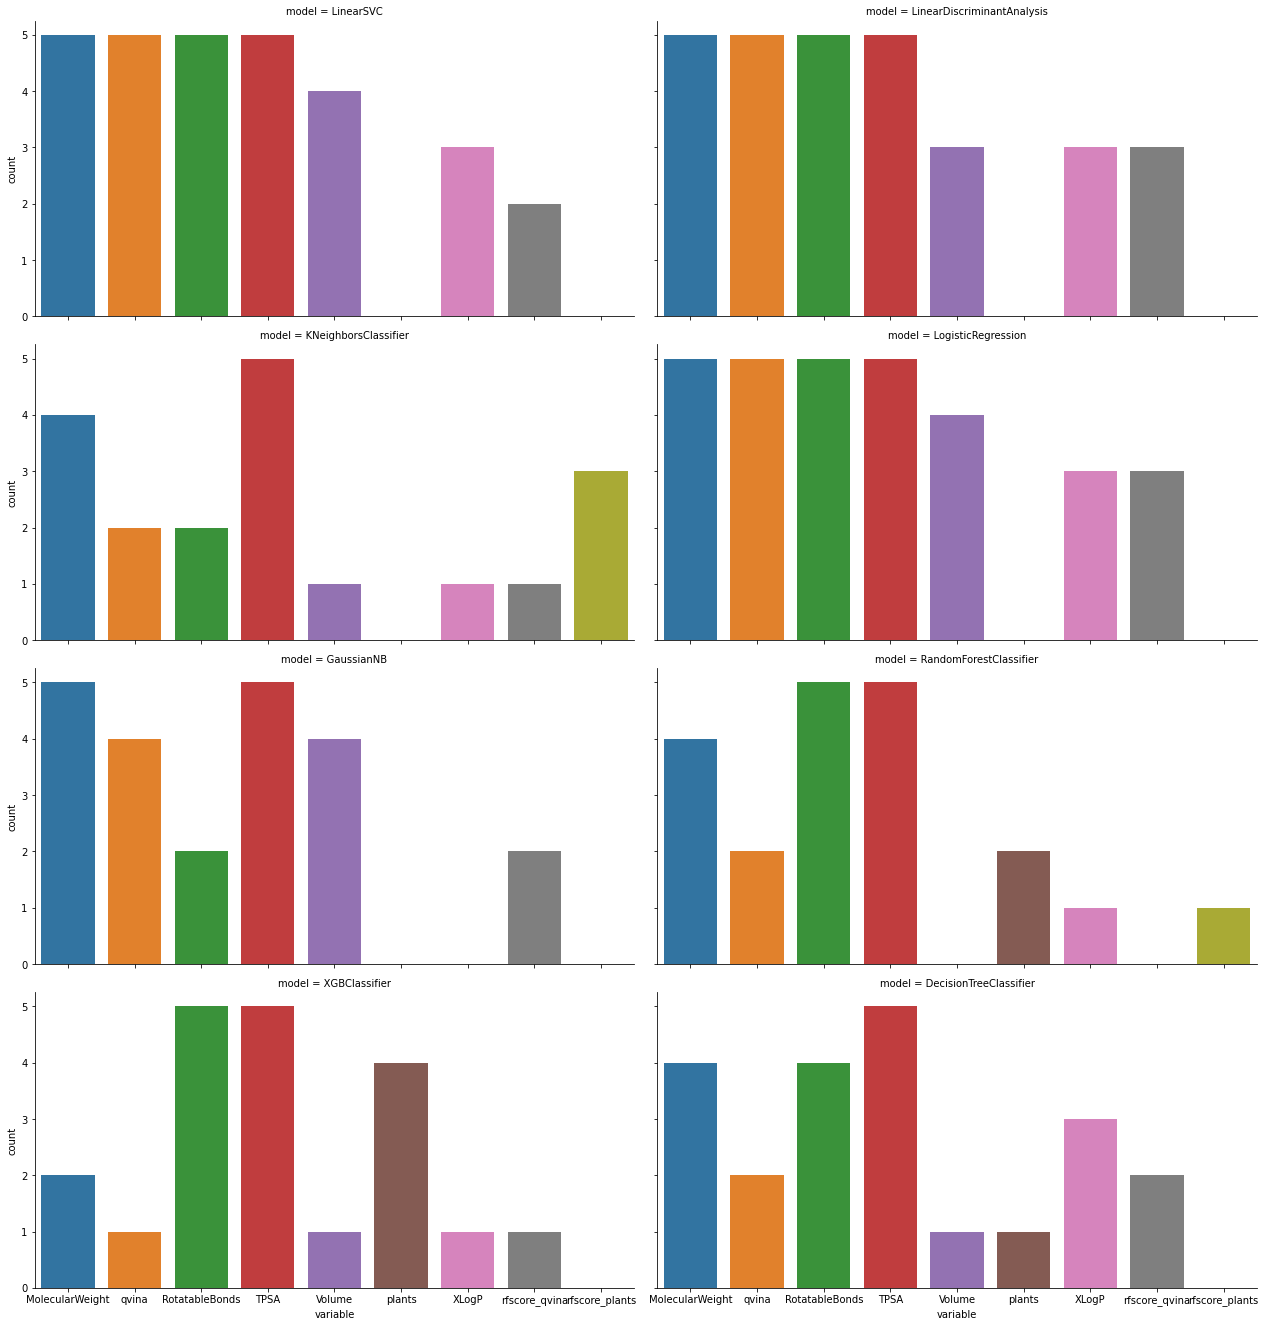

In [54]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=train_set, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=1.75)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most frequent descriptors in the top 1% scores')

The frequency count shows the most recurring descriptors in each model's top 1% results are: 

In [60]:
for key, value in best_subset.items():
    print(f'{key} : {value[1]}')

RandomForestClassifier : ['RotatableBonds', 'TPSA', 'MolecularWeight', 'XLogP', 'plants']
XGBClassifier : ['RotatableBonds', 'TPSA', 'MolecularWeight', 'plants']
LogisticRegression : ['Volume', 'RotatableBonds', 'TPSA', 'MolecularWeight', 'XLogP', 'qvina', 'rfscore_qvina']
LinearSVC : ['Volume', 'RotatableBonds', 'TPSA', 'MolecularWeight', 'XLogP', 'qvina', 'rfscore_qvina']
KNeighborsClassifier : ['TPSA', 'MolecularWeight', 'rfscore_plants']
DecisionTreeClassifier : ['RotatableBonds', 'TPSA', 'MolecularWeight']
LinearDiscriminantAnalysis : ['Volume', 'RotatableBonds', 'TPSA', 'MolecularWeight', 'XLogP', 'qvina', 'rfscore_qvina']
GaussianNB : ['TPSA', 'MolecularWeight', 'qvina', 'rfscore_qvina']


In [56]:
# Completar overview
# Pesquisar sobre elbow method
# Pesquisar sobre metricas
# Importar rdkit e calcular dentro do notebook